In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import ProbNumPy as pnp

In [2]:
def k_gauss(x, x_prime, lambd, sigma):
    cov = sigma**2 * np.eye(x.shape[0])
    ret = lambd**2 * (np.sqrt(2*np.pi)*sigma)**(len(x))
    # have to ravel here because scipy uses reshape
    ret = ret * scipy.stats.multivariate_normal.pdf(x.ravel(), x_prime.ravel(), cov)
    #return lambd**2 * np.exp(-np.sum((x-x_prime)**2) * 1./(2*sigma**2))
    return ret

def k_mean_map_gauss(x, mu_1, cov_1, lambd, sigma):
    cov = sigma**2 * np.eye(x.shape[0])
    return lambd**2 * (np.sqrt(2*np.pi)*sigma)**(len(x)) * scipy.stats.multivariate_normal.pdf(x.ravel(), mu_1.ravel(), cov_1 + cov)

def k_mean_map_gauss_mixture(x, mus, covs, rhos, lambd, sigma):
    mix_elts = np.array([k_mean_map_gauss(x, mu_l, cov_l, lambd, sigma) for mu_l, cov_l in zip(mus, covs)])
    return np.sum(rhos * mix_elts)

# 1D Example

In [3]:
lambd = 1.
sigma = 1.
mu = np.array([[0.]])
cov = np.array([[1.]])

kernel = lambda x, x_prime: k_gauss(x, x_prime, lambd, sigma)
kernel_mm = lambda x: k_mean_map_gauss(x, mu, cov, lambd, sigma)
#compute_weights(points, kernel, kernel_mm)

In [4]:
test_points = np.sort(np.random.normal(mu, cov, 1000).ravel())[:,None]
init = np.array([[0.]])
points, weights = pnp.integrate.frank_wolfe(init, 25, kernel, kernel_mm, test_points)

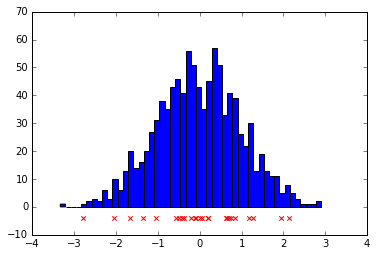

In [5]:
plt.hist(test_points, bins=50)
plt.scatter(points, np.zeros_like(points) - 4., marker='x', c='r')

# 2D Example

In [6]:
sigma = 0.8
mus = [
    np.array([4.443438, 3.097593]),
    np.array([-5.592092, -2.150316])
]
sigmas = [
    np.array([[6.761966, 1.400297], [1.400297, 7.058602]]),
    np.array([[5.6483550, 0.4685284], [0.4685284, 9.2519292]])
]
mix_weights = [
    0.465227,
    0.534773
]
mix_kernel = lambda x, x_prime: kernel(x.ravel(), x_prime.ravel())
mix_kernel_mm = lambda x: k_mean_map_gauss_mixture(x, mus, sigmas, mix_weights, lambd, sigma)

In [7]:
def mixture_gaussian(mus, sigmas, weights, n):
    indexes = np.random.choice(len(weights), size=n, p=weights)
    ret = np.empty((n, len(mus[0])))
    for i, ix in enumerate(indexes):
        ret[i, :] = scipy.stats.multivariate_normal.rvs(mus[ix], sigmas[ix])
    return ret

In [8]:
test_points = mixture_gaussian(mus, sigmas, mix_weights, 2500)

In [9]:
fw_points, fw_weights = pnp.integrate.frank_wolfe(np.array([[0.,0.]]), 10, mix_kernel, mix_kernel_mm, test_points)
fw_points_kh, fw_weights_kh = pnp.integrate.frank_wolfe(np.array([[0.,0.]]), 10, mix_kernel, mix_kernel_mm, test_points, 'kernel-herding')

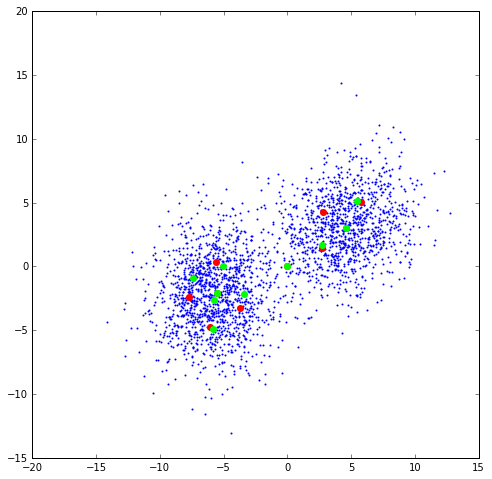

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(test_points[:,0], test_points[:,1], linewidth=0, s=4, label='Candidates')
plt.scatter(fw_points_kh[:,0], fw_points_kh[:,1], linewidth=0, s=50, c='red', label='KH Points')
plt.scatter(fw_points[:, 0], fw_points[:,1], linewidths=0, s=50, c='lime', label='LS Points');